In [1]:
from typing import List, Optional, Sequence, Set
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

def visualize_classes(df):
    fig = plt.figure()
    plt.scatter(df["Class"], df.Y)
    ax = fig.axes[0]
    ax.set_xlabel("Class")
    ax.set_ylabel("Y")
    ax.set_title("Diabetes Y Classes")

# Our custom Dataset. Useful reference:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class DiabetesDataset(Dataset):
    df: pd.DataFrame

    x_include: Set[str]
    y_column: str
    y_dtype: torch.dtype

    def __init__(self,
                 df: pd.DataFrame,
                 x_include: Sequence[str],
                 y_column: str,
                 y_dtype: torch.dtype = torch.long,
    ):
        self.df = df
        self.x_include = set(x_include)
        self.y_column = y_column
        self.y_dtype = y_dtype
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> torch.Tensor:
        x = self.df.loc[index, (col in self.x_include for col in self.df.columns)].values
        y = self.df.loc[index, self.df.columns == self.y_column].values
        return (
            torch.tensor(x).float(),
            torch.tensor(y).squeeze().to(self.y_dtype))

class ClassPredictor:

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 learning_rate: float = 0.1,
    ):
        
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, out_features),
            nn.LogSoftmax(dim=1)
        )

        self.loss = nn.NLLLoss()

        self.optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=learning_rate)

    def forward_batch(self, batch, optimize: bool = True):
        xs, ys = batch

        if optimize:
            # new batch, zero all gradients
            self.optimizer.zero_grad()

        # feed forwad
        output = self.model(xs)

        # compute loss and gradients
        loss = self.loss(output, ys)
        loss.backward()

        if optimize:
            # update model parameters
            self.optimizer.step()

        # calculate the accuracy.
        # `inferred_classes` gets, from each entry in the batch the highest probability class.
        # then, we count how many classes the model got right, and divide by total classes
        # in order to normalize for a relative error.
        inferred_classes = output.argmax(dim=1)
        accuracy = (inferred_classes == ys).sum() / len(ys)

        return loss.detach(), accuracy.detach()

    def forward(self, dataloader: DataLoader, optimize: bool = True):
        total_batches = len(dataloader)

        loss_sum = 0
        accuracy_sum = 0

        for batch in dataloader:
            loss, accuracy = self.forward_batch(batch, optimize=optimize)
            loss_sum += loss
            accuracy_sum += accuracy

        return float(loss_sum) / total_batches, float(accuracy_sum) / total_batches

    def train(self,
              epochs: int,
              dataloader: DataLoader,
              plot: bool = False,
              plot_suptitle: Optional[str] = None,
        ):
    
        losses = torch.empty(epochs)
        accuracies = torch.empty(epochs)

        print("Training ", end="")
        for epoch in range(epochs):
            print(".", end="", flush=True)
            loss, accuracy = self.forward(dataloader)
            losses[epoch] = loss
            accuracies[epoch] = accuracy
        print()

        if plot:
            self.plot_train_results(plot_suptitle, losses, accuracies)

        return losses[-1], accuracies[-1]

    def plot_train_results(self, suptitle, losses, accuracies):
        fig = plt.figure()
        fig.suptitle(suptitle)
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(range(len(losses)), losses)
        plt.xlabel("Epoch")

        plt.subplot(1, 2, 2)
        plt.plot(range(len(accuracies)), accuracies)
        plt.title("Accuracy")
        plt.xlabel("Epoch")

    def evaluate_model(self, dataloader: DataLoader) -> float:
        loss, accuracy = self.forward(dataloader, optimize=False)
        return accuracy

def partition_dataframe(df: pd.DataFrame, frac: float) -> pd.DataFrame:
    a = df.copy()
    b = a.sample(frac=frac)
    
    a.drop(b.index)
    a = a.reset_index()
    b = b.reset_index()

    return a, b

def train_and_evaluate(
        training_dataset: Dataset, test_dataset: Dataset,
        output_features: int,
        experiment_name: str, experiment_variant: str):
    input_features = len(training_dataset[0][0])

    predictor = ClassPredictor(
        in_features=input_features,
        out_features=output_features,
        learning_rate=lr)

    _, training_accuracy = predictor.train(
        epochs,
        DataLoader(training_dataset, batch_size),
        plot=plot,
        plot_suptitle=f"{experiment_name} - {experiment_variant}")

    test_accuracy = predictor.evaluate_model(
        DataLoader(test_dataset))

    print(f"Experiment: {experiment_name}, {experiment_variant}")
    print(f" - Final training accuracy: {training_accuracy}")
    print(f" - Final test accuracy: {test_accuracy}")

    if print_model_vs_actual:
        for (xs, ys) in DataLoader(test_dataset, batch_size=1):
            result = predictor.model(xs)
            print(f"Model: {result[0].argmax()}, Actual: {ys[0]}")

In [2]:
epochs = 100
plot = True
print_model_vs_actual = False
lr = 0.01
batch_size = 10

print("Epochs: ", epochs)
print("Learning Rate: ", lr)
print("Batch Size: ", batch_size)

diabetes_df = pd.read_csv("assets/diabetes.csv", sep="\t")

def run_experiments(quantiles, variant_name):
    diabetes_df['Class'] = pd.qcut(diabetes_df.Y, quantiles, labels=False)

    # The training and test set contains 80% and 20% from the dataset respectively.
    training_df, test_df = partition_dataframe(diabetes_df, frac=0.2)

    training_dataset_with_y = DiabetesDataset(
        training_df,
        x_include=[col for col in diabetes_df.columns if col not in ("Class")],
        y_column="Class")

    test_dataset_with_y = DiabetesDataset(
        test_df,
        x_include=[col for col in diabetes_df.columns if col not in ("Class")],
        y_column="Class")

    training_dataset_without_y = DiabetesDataset(
        training_df,
        x_include=[col for col in diabetes_df.columns if col not in ("Class", "Y")],
        y_column="Class")

    test_dataset_without_y = DiabetesDataset(
        test_df,
        x_include=[col for col in diabetes_df.columns if col not in ("Class", "Y")],
        y_column="Class")

    # Visualize the quantiles
    visualize_classes(diabetes_df)

    if quantiles == 0:
        # Just print, like required in the mmn
        print(next(iter(DataLoader(training_dataset_with_y, batch_size))))

    # Train and evaluate a predictor for Class that is trained on all fields including Y
    train_and_evaluate(training_dataset_with_y, test_dataset_with_y,
                       quantiles,
                       "Predict Class with Y", variant_name)

    # Train and evaluate a predictor for Class that is trained on all fields except Y
    train_and_evaluate(training_dataset_without_y, test_dataset_without_y,
                       quantiles,
                       "Predict Class without Y", variant_name)

Epochs:  100
Learning Rate:  0.01
Batch Size:  10


Training ....................................................................................................
Experiment: Predict Class with Y, Deciles
 - Final training accuracy: 0.5555555820465088
 - Final test accuracy: 0.6818181818181818
Training ....................................................................................................
Experiment: Predict Class without Y, Deciles
 - Final training accuracy: 0.31555554270744324
 - Final test accuracy: 0.23863636363636365


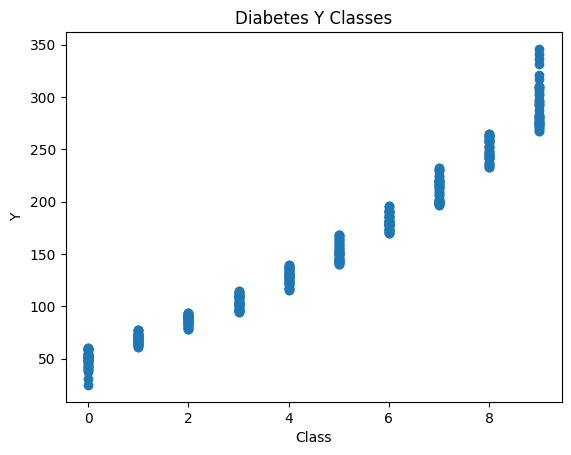

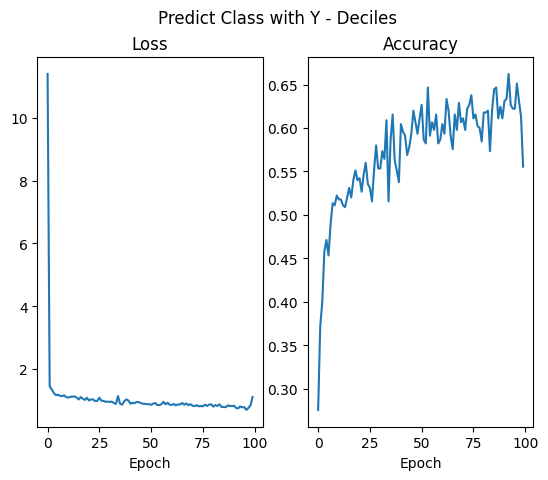

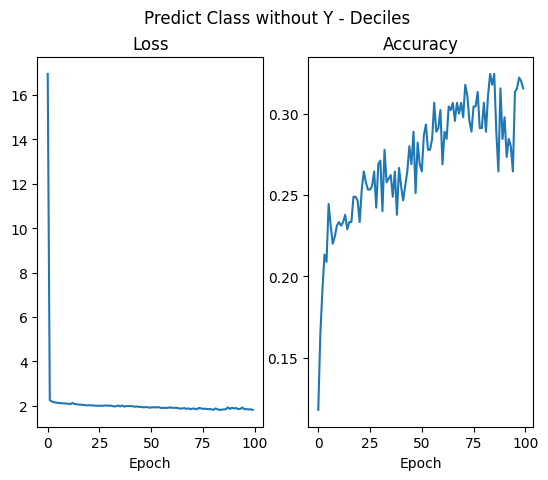

In [3]:
run_experiments(10, "Deciles")

Training ....................................................................................................
Experiment: Predict Class with Y, Percentiles
 - Final training accuracy: 0.3333333134651184
 - Final test accuracy: 0.2159090909090909
Training ....................................................................................................
Experiment: Predict Class without Y, Percentiles
 - Final training accuracy: 0.3311110734939575
 - Final test accuracy: 0.20454545454545456


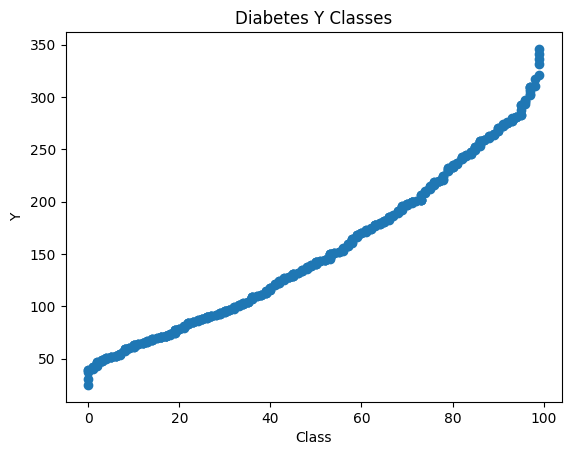

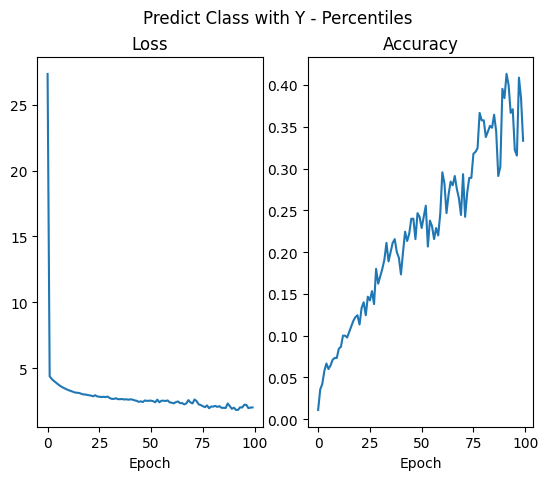

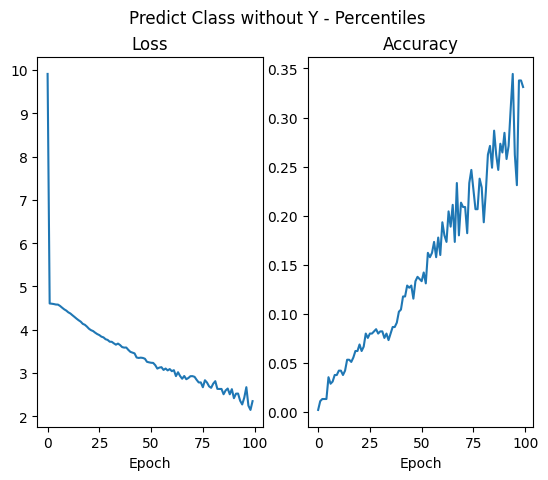

In [4]:
run_experiments(100, "Percentiles")

In [5]:
class FeatureRegression:
    def __init__(self,
                 in_features: int,
                 learning_rate: float = 0.1,
    ):
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, in_features),
            nn.ReLU(),
            nn.Linear(in_features, 1),
        )

        self.loss = nn.MSELoss()

        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=learning_rate)

    def forward_batch(self, batch, optimize: bool = True):
        xs, ys = batch

        if optimize:
            # new batch, zero all gradients
            self.optimizer.zero_grad()

        # feed forwad
        output = self.model(xs).squeeze()

        # compute loss and gradients
        loss = self.loss(output, ys)
        loss.backward()

        if optimize:
            # update model parameters
            self.optimizer.step()

        # average distance 
        err = torch.abs(output - ys).mean()

        return loss.detach(), err.detach()

    def forward(self, dataloader: DataLoader, optimize: bool = True):
        total_batches = len(dataloader)

        loss_sum = 0
        err_sum = 0

        for batch in dataloader:
            loss, err = self.forward_batch(batch, optimize=optimize)
            loss_sum += loss
            err_sum += err

        return float(loss_sum) / total_batches, float(err_sum) / total_batches

    def train(self,
              epochs: int,
              dataloader: DataLoader,
              plot: bool = False,
              plot_suptitle: Optional[str] = None,
        ):
    
        losses = torch.empty(epochs)
        errors = torch.empty(epochs)

        print("Training ", end="")
        for epoch in range(epochs):
            print(".", end="", flush=True)
            loss, accuracy = self.forward(dataloader)
            losses[epoch] = loss
            errors[epoch] = accuracy
        print()

        if plot:
            self.plot_train_results(plot_suptitle, losses, errors)

        return losses[-1], errors[-1]

    def plot_train_results(self, suptitle, losses, errors):
        fig = plt.figure()
        fig.suptitle(suptitle)
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(range(len(losses)), losses)
        plt.xlabel("Epoch")

        plt.subplot(1, 2, 2)
        plt.plot(range(len(errors)), errors)
        plt.title("Error")
        plt.xlabel("Epoch")

    def evaluate_model(self, dataloader: DataLoader) -> float:
        _, err = self.forward(dataloader, optimize=False)
        return err 

Epochs:  100
Learning Rate:  0.01
Batch Size:  10
Training ....................................................................................................
Experiment: Y Regression
 - Final training error: 46.899723052978516
 - Final test error: 53.70623440212674


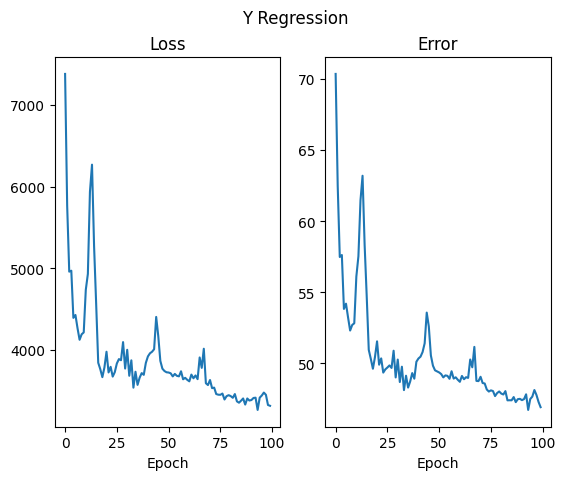

In [6]:
epochs = 100
plot = True
print_model_vs_actual = False
lr = 0.01
batch_size = 10

print("Epochs: ", epochs)
print("Learning Rate: ", lr)
print("Batch Size: ", batch_size)

diabetes_df = pd.read_csv("assets/diabetes.csv", sep="\t")

training_df, test_df = partition_dataframe(diabetes_df, frac=0.2)

training_dataset_for_regression = DiabetesDataset(
    training_df,
    x_include=(col for col in training_df.columns if col != 'Y'),
    y_column='Y', y_dtype=torch.float)

test_dataset_for_regression = DiabetesDataset(
    test_df,
    x_include=(col for col in training_df.columns if col != 'Y'),
    y_column='Y', y_dtype=torch.float)

regression = FeatureRegression(len(training_df.columns) - 1, learning_rate=lr)

train_loss, train_err = regression.train(
    epochs, DataLoader(training_dataset_for_regression, batch_size), plot, "Y Regression")

test_err = regression.evaluate_model(DataLoader(test_dataset_for_regression, batch_size))

print(f"Experiment: Y Regression")
print(f" - Final training error: {train_err}")
print(f" - Final test error: {test_err}")

if print_model_vs_actual:
    for (xs, ys) in DataLoader(test_dataset_for_regression, batch_size=1):
        result = regression.model(xs)
        print(f"Model: {result[0].item()}, Actual: {ys[0]}")